In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pylab as plt
import numpy as np
import torch
import swyft.lightning as sl

In [3]:
def simulator(v, w = 0.03):
    "Ring simulator"
    x1, y1, r = v
    
    grid = np.linspace(0, 1, 32, 32)
    X, Y = np.meshgrid(grid, grid)
    
    R1 = ((X-x1)**2 + (Y-y1)**2)**0.5
    mu = np.exp(-(R1-r)**2/w**2/2)
    
    # Add random distortions in terms of lines
    for _ in range(20):
        xr = np.random.rand(2)
        mu += 0.8*np.exp(-(X*xr[0]+Y*(1-xr[0])-xr[1])**2/0.01**2)
        
    return {"img": np.expand_dims(np.array(mu), 0)}

100%|██████████| 1/1 [00:00<00:00, 2291.97it/s]


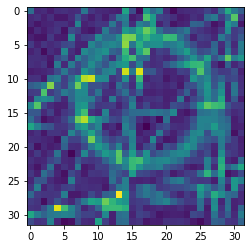

In [4]:
class Model(sl.SwyftModel):
    def fast(self, S):
        d = S['mu'] + torch.randn_like(S['mu'])*0.1
        return sl.SampleStore(data = d)
        
    def slow(self, v, w = 0.03):
        "Ring simulator"
        x1, y1, r = np.array(v['z'])

        grid = np.linspace(0, 1, 32, 32)
        X, Y = np.meshgrid(grid, grid)

        R1 = ((X-x1)**2 + (Y-y1)**2)**0.5
        mu = np.exp(-(R1-r)**2/w**2/2)

        # Add random distortions in terms of lines
        for _ in range(20):
            xr = np.random.rand(2)
            mu += 0.8*np.exp(-(X*xr[0]+Y*(1-xr[0])-xr[1])**2/0.01**2)

        return {"mu": torch.tensor(np.array(mu)).float()}
        

    def prior(self, N, bounds = None):
        low = np.zeros(3)
        high = np.array([1., 1., 0.5])        
        if bounds is not None:
            low, high = bounds['z'].low, bounds['z'].high
        draw = np.array([np.random.uniform(low=low, high=high) for _ in range(N)])
        return sl.SampleStore(z = torch.tensor(draw).float())
    
m = Model()
s0 = m.sample(1)[0]
mu = s0['data']
plt.imshow(mu)

## Definition of target image

In [5]:
class InferenceNet(sl.SwyftModule):
    def __init__(self):
        super().__init__()
        #self.online_z_score = swyft.networks.OnlineDictStandardizingLayer(dict(img = (50, 50)))
        self.CNN = torch.nn.Sequential(
            torch.nn.Conv2d(1, 10, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(10, 20, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Flatten(),
            torch.nn.LazyLinear(128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 16),
        )
        self.classifier = sl.RatioEstimatorMLP1d(16, 3, hidden_features = 256)

    def forward(self, x, z):
        # Digesting x
        data = x['data']
        #x = self.online_z_score(x)['img']
        x = self.CNN(data.unsqueeze(1)).squeeze(1)
        
        out = self.classifier(x, z['z'])
        return dict(z = out)

## Workflow

In [6]:
m = Model()
s = m.sample(10000)

100%|██████████| 10000/10000 [00:00<00:00, 38699.95it/s]


In [7]:
# Access of individual samples
s[0]

{'data': tensor([[ 1.3511e-01,  6.7952e-01, -7.3385e-02,  ..., -8.5546e-02,
          -2.1729e-02,  5.0527e-02],
         [ 7.2049e-01, -8.2875e-02, -1.0720e-02,  ..., -5.8736e-04,
          -2.0108e-02,  1.8704e-01],
         [-2.0871e-02, -1.3350e-01,  1.5413e-03,  ..., -7.9641e-03,
          -3.3055e-02,  3.6501e-02],
         ...,
         [ 2.5786e-01,  1.0513e+00,  7.5526e-01,  ...,  1.4545e-01,
           9.7292e-02,  2.9071e-01],
         [ 7.4288e-02,  2.1700e-01,  6.2480e-01,  ...,  7.1238e-02,
           2.1727e-01,  2.9585e-01],
         [ 1.6634e+00,  1.5161e+00,  2.8888e-01,  ...,  6.7567e-01,
           8.8774e-02,  1.0276e-01]]),
 'z': tensor([0.5891, 0.4321, 0.0355]),
 'mu': tensor([[1.7990e-01, 5.7314e-01, 2.8200e-03,  ..., 7.4321e-38, 1.9944e-24,
          5.2134e-14],
         [7.6702e-01, 1.4406e-02, 1.5994e-05,  ..., 1.0053e-27, 1.6790e-16,
          2.7330e-08],
         [5.5777e-02, 6.1775e-06, 4.6374e-03,  ..., 1.0685e-16, 3.4633e-10,
          3.4723e-04],
   

In [8]:
# Access of all samples with specific key
s['z']

tensor([[0.5891, 0.4321, 0.0355],
        [0.3243, 0.2568, 0.0443],
        [0.2520, 0.4151, 0.4496],
        ...,
        [0.7312, 0.5683, 0.1254],
        [0.7866, 0.2162, 0.2050],
        [0.2644, 0.1550, 0.4171]])

In [9]:
r = InferenceNet()
d = sl.SwyftDataModule(store = s, model = None, batch_size = 64)

/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/torch-1.9.0-py3.8-linux-x86_64.egg/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [10]:
t = sl.SwyftTrainer(accelerator = 'gpu', gpus=1, max_epochs = 30)
t.fit(r, d)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/utilities/model_summary.py:438: UserWarning: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
  warning_cache.warn(

  | Name       | Type                | Params
---------------------------------------------------
0 | CNN        | Sequential          | 4.0 K 
1 | classifier | RatioEstimatorMLP1d | 810 K 
---------------------------------------------------
814 K     Trainable params
0         Non-trainable params
814 K     Total params
3.257     Total estimated model params size (MB)
/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/weniger/codes/swyft/notebooks/lightning_logs/version_8773359/c

Validation sanity check: 0it [00:00, ?it/s]

/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/torch-1.9.0-py3.8-linux-x86_64.egg/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/torch-1.9.0-py3.8-linux-x86_64.egg/torch/nn/_reduction.py:42: UserWarning: size_avera

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [11]:
t.test(r, d)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'hp/JS-div': 1.5385677814483643, 'hp/KL-div': -6.279937267303467}
--------------------------------------------------------------------------------


[{'hp/JS-div': 1.5385677814483643, 'hp/KL-div': -6.279937267303467}]

In [12]:
p = t.infer(r, d, condition_x = s0)   # Weighted posterior samples
p

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 125it [00:00, ?it/s]

{'z': RatioSamples(values=tensor([[0.5891, 0.4321, 0.0355],
         [0.3243, 0.2568, 0.0443],
         [0.2520, 0.4151, 0.4496],
         ...,
         [0.7312, 0.5683, 0.1254],
         [0.7866, 0.2162, 0.2050],
         [0.2644, 0.1550, 0.4171]]), ratios=tensor([[ -5.4465,   3.0897, -34.4117],
         [-17.2475, -14.7515, -32.7098],
         [-21.2518,   2.3596, -22.7513],
         ...,
         [-18.3723, -12.4535, -18.6121],
         [-20.7750, -17.5404, -12.5767],
         [-20.7174, -21.5438, -18.9978]]), metadata={})}

In [13]:
ps = p.sample(10000)
ps

{'z': tensor([[0.5041, 0.4351, 0.2948],
         [0.4855, 0.4654, 0.2774],
         [0.4896, 0.4182, 0.2819],
         ...,
         [0.4988, 0.4221, 0.3044],
         [0.5162, 0.4211, 0.2746],
         [0.5132, 0.4308, 0.3012]])}

In [14]:
b = sl.get_1d_rect_bounds(p, th = 1e-6)
b

{'z': RectangleBound(low=tensor([0.3967, 0.3084, 0.2260]), high=tensor([0.6284, 0.5461, 0.3598]))}

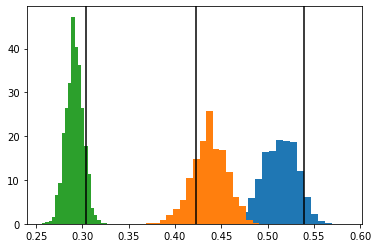

In [17]:
z = ps['z']
z0 = s0['z']
plt.hist(z[:,0].numpy(), bins = 20, density=True);
plt.hist(z[:,1].numpy(), bins = 20, density = True);
plt.hist(z[:,2].numpy(), bins = 20, density = True);
plt.axvline(z0[0], color='k')
plt.axvline(z0[1], color='k')
plt.axvline(z0[2], color='k')